# Waiter's Tip Dataset

Table of Contents:

1. Data Analysis
    - Data Description
    - Data Loading
    - Data Preprocessing
    - Exploratory Data Analysis (EDA)
        - Correlation Heatmap
        - Distribution Plots
        - Box Plots
        - Count Plots
    - Statistical Tests
        - t-test
        - ANOVA-F-test
2. Machine Learning
    - Model Selection
    - Model Evaluation
3. Conclusions

# 1. Data Analysis

## Data Description

(https://www.kaggle.com/datasets/jsphyg/tipping)

Ever wonder how much to tip your waiter? One dedicated waiter meticulously recorded information about each tip he received over a few months while working at a restaurant. In total, he documented 244 tips. 

Columns (7): 

    - Total Bill (dollars)
    - Tip (dollars)
    - Sex (Male/Female)
    - Smoker (Yes/No)
    - Day (Mon/Tue/Wed/Thu/Fri/Sat/Sun)
    - Time (Dinner/Lunch)
    - Size [of party] (number)

## Loading Data

In [56]:
import pandas as pd
from pandas.api.types import is_string_dtype
from pandas.api.types import is_numeric_dtype
import seaborn as sns
sns.set_theme(style='ticks')
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm, skew, ttest_ind, f_oneway

from sklearn.preprocessing import LabelEncoder, PowerTransformer, StandardScaler

In [57]:
#Create DataFrame object
df = pd.read_csv('tips.csv'); df.head()

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4


## Data Pre-processing

In [58]:
df.describe()

,total_bill,tip,size
count,244.000000,244.000000,244.000000
mean,19.785943,2.998279,2.569672
std,8.902412,1.383638,0.951100
min,3.070000,1.000000,1.000000
25%,13.347500,2.000000,2.000000
50%,17.795000,2.900000,2.000000
75%,24.127500,3.562500,3.000000
max,50.810000,10.000000,6.000000


In [59]:
#Check for NA values
df.isnull().sum()

total_bill    0
tip           0
sex           0
smoker        0
day           0
time          0
size          0
dtype: int64

In [60]:
#Check for duplicates
df.duplicated().sum()

1

In [61]:
#Remove duplicates and confirm removal
df.drop_duplicates(inplace=True); df.duplicated().sum()

0

In [62]:
df

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4
...,...,...,...,...,...,...,...
239,29.03,5.92,Male,No,Sat,Dinner,3
240,27.18,2.00,Female,Yes,Sat,Dinner,2
241,22.67,2.00,Male,Yes,Sat,Dinner,2
242,17.82,1.75,Male,No,Sat,Dinner,2


In [63]:
#Define categorical and numerical columns
categorical_cols = []
numerical_cols = []

for col in df.columns:
    if (is_string_dtype(df[col])):
        categorical_cols.append(col)
    else:
        numerical_cols.append(col)

In [64]:
print(f'Categorical columns: {categorical_cols}\nNumerical columns: {numerical_cols}')

Categorical columns: ['sex', 'smoker', 'day', 'time']
Numerical columns: ['total_bill', 'tip', 'size']


In [65]:
#Removing outliers outside IQR (Inter-Quantile Range) on numerical columns
def remove_outliers(df, columns):
    for i, col in enumerate(columns):
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - IQR * 1.5
        upper_bound = Q3 + IQR * 1.5
        df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
    return df

In [66]:
df = remove_outliers(df, numerical_cols)

In [67]:
#One-hot encoding categorical columns
label_dict = {}
labeler = LabelEncoder()
for i,col in enumerate(categorical_cols):
    df[col] = labeler.fit_transform(df[col])
    label_dict[col] = labeler

In [68]:
df

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,0,0,2,0,2
1,10.34,1.66,1,0,2,0,3
2,21.01,3.50,1,0,2,0,3
3,23.68,3.31,1,0,2,0,2
4,24.59,3.61,0,0,2,0,4
...,...,...,...,...,...,...,...
238,35.83,4.67,0,0,1,0,3
240,27.18,2.00,0,1,1,0,2
241,22.67,2.00,1,1,1,0,2
242,17.82,1.75,1,0,1,0,2


In [69]:
len(numerical_cols)

3

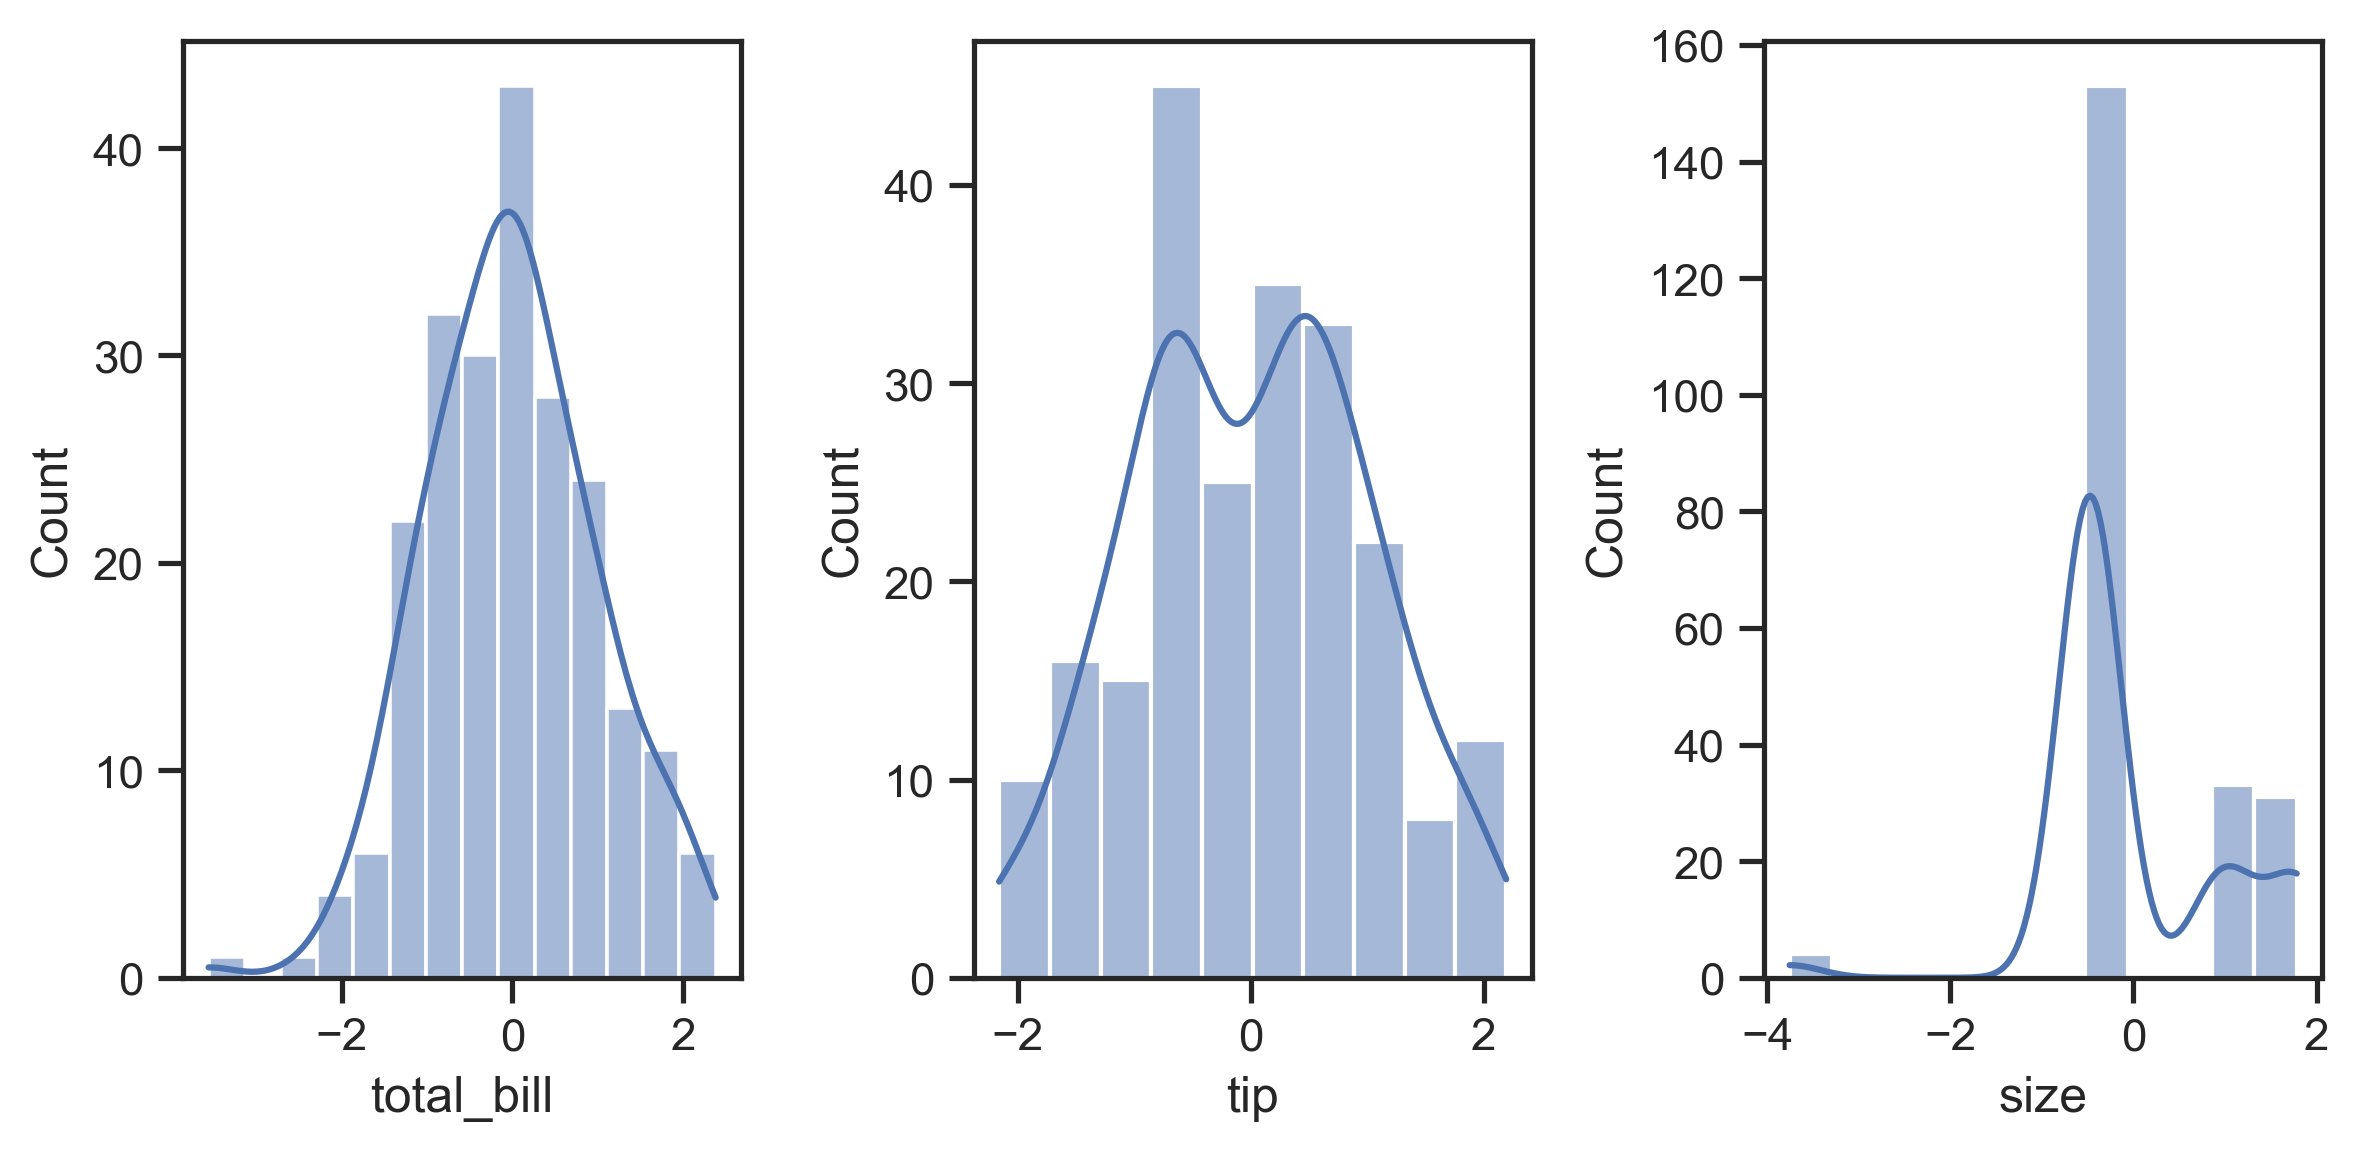

In [93]:
#Checking distributions of numerical columns
fig = plt.figure(figsize=(8,4), dpi=300)
for i,col in enumerate(numerical_cols):
    plt.subplot(1, 3, i+1)
    sns.histplot(data=df, x=col, kde=True)
plt.tight_layout()
plt.show()

The numerical data is obviously skewed:

In [71]:
for col in numerical_cols:
    print(f'Skewness of {col}: {skew(df[col])}')

Skewness of total_bill: 0.8271368500606552
Skewness of tip: 0.5568756361580495
Skewness of size: 1.1799688899063168


In [72]:
def normalize_skew(df, columns):
    transformer = PowerTransformer(method='yeo-johnson')
    for i, col in enumerate(columns):
        if abs(skew(df[col])) > 0.5:
            df[col] = transformer.fit_transform(df[col].values.reshape(-1,1))
    return df


In [73]:
df = normalize_skew(df, numerical_cols)

The skew has now been brought within the range (-0.5, 0.5):

In [74]:
for col in numerical_cols:
    print(f'Skewness of {col}: {skew(df[col])}')

Skewness of total_bill: 0.0033815001040292214
Skewness of tip: 0.0010669007498665766
Skewness of size: -0.09674408612937464


## Exploratory Data Analysis

<Axes: >

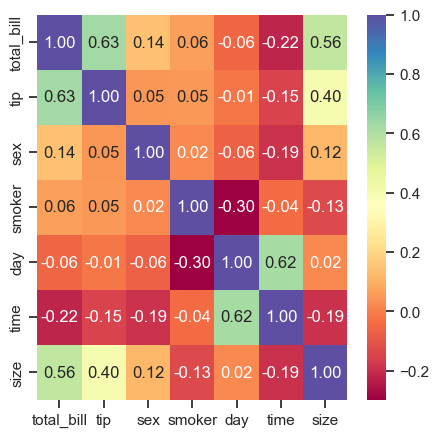

In [88]:
# Correlation Heatmap
figure = plt.figure(figsize=(5,5))
sns.heatmap(df.corr(), annot=True, fmt='.2f', cmap='Spectral')

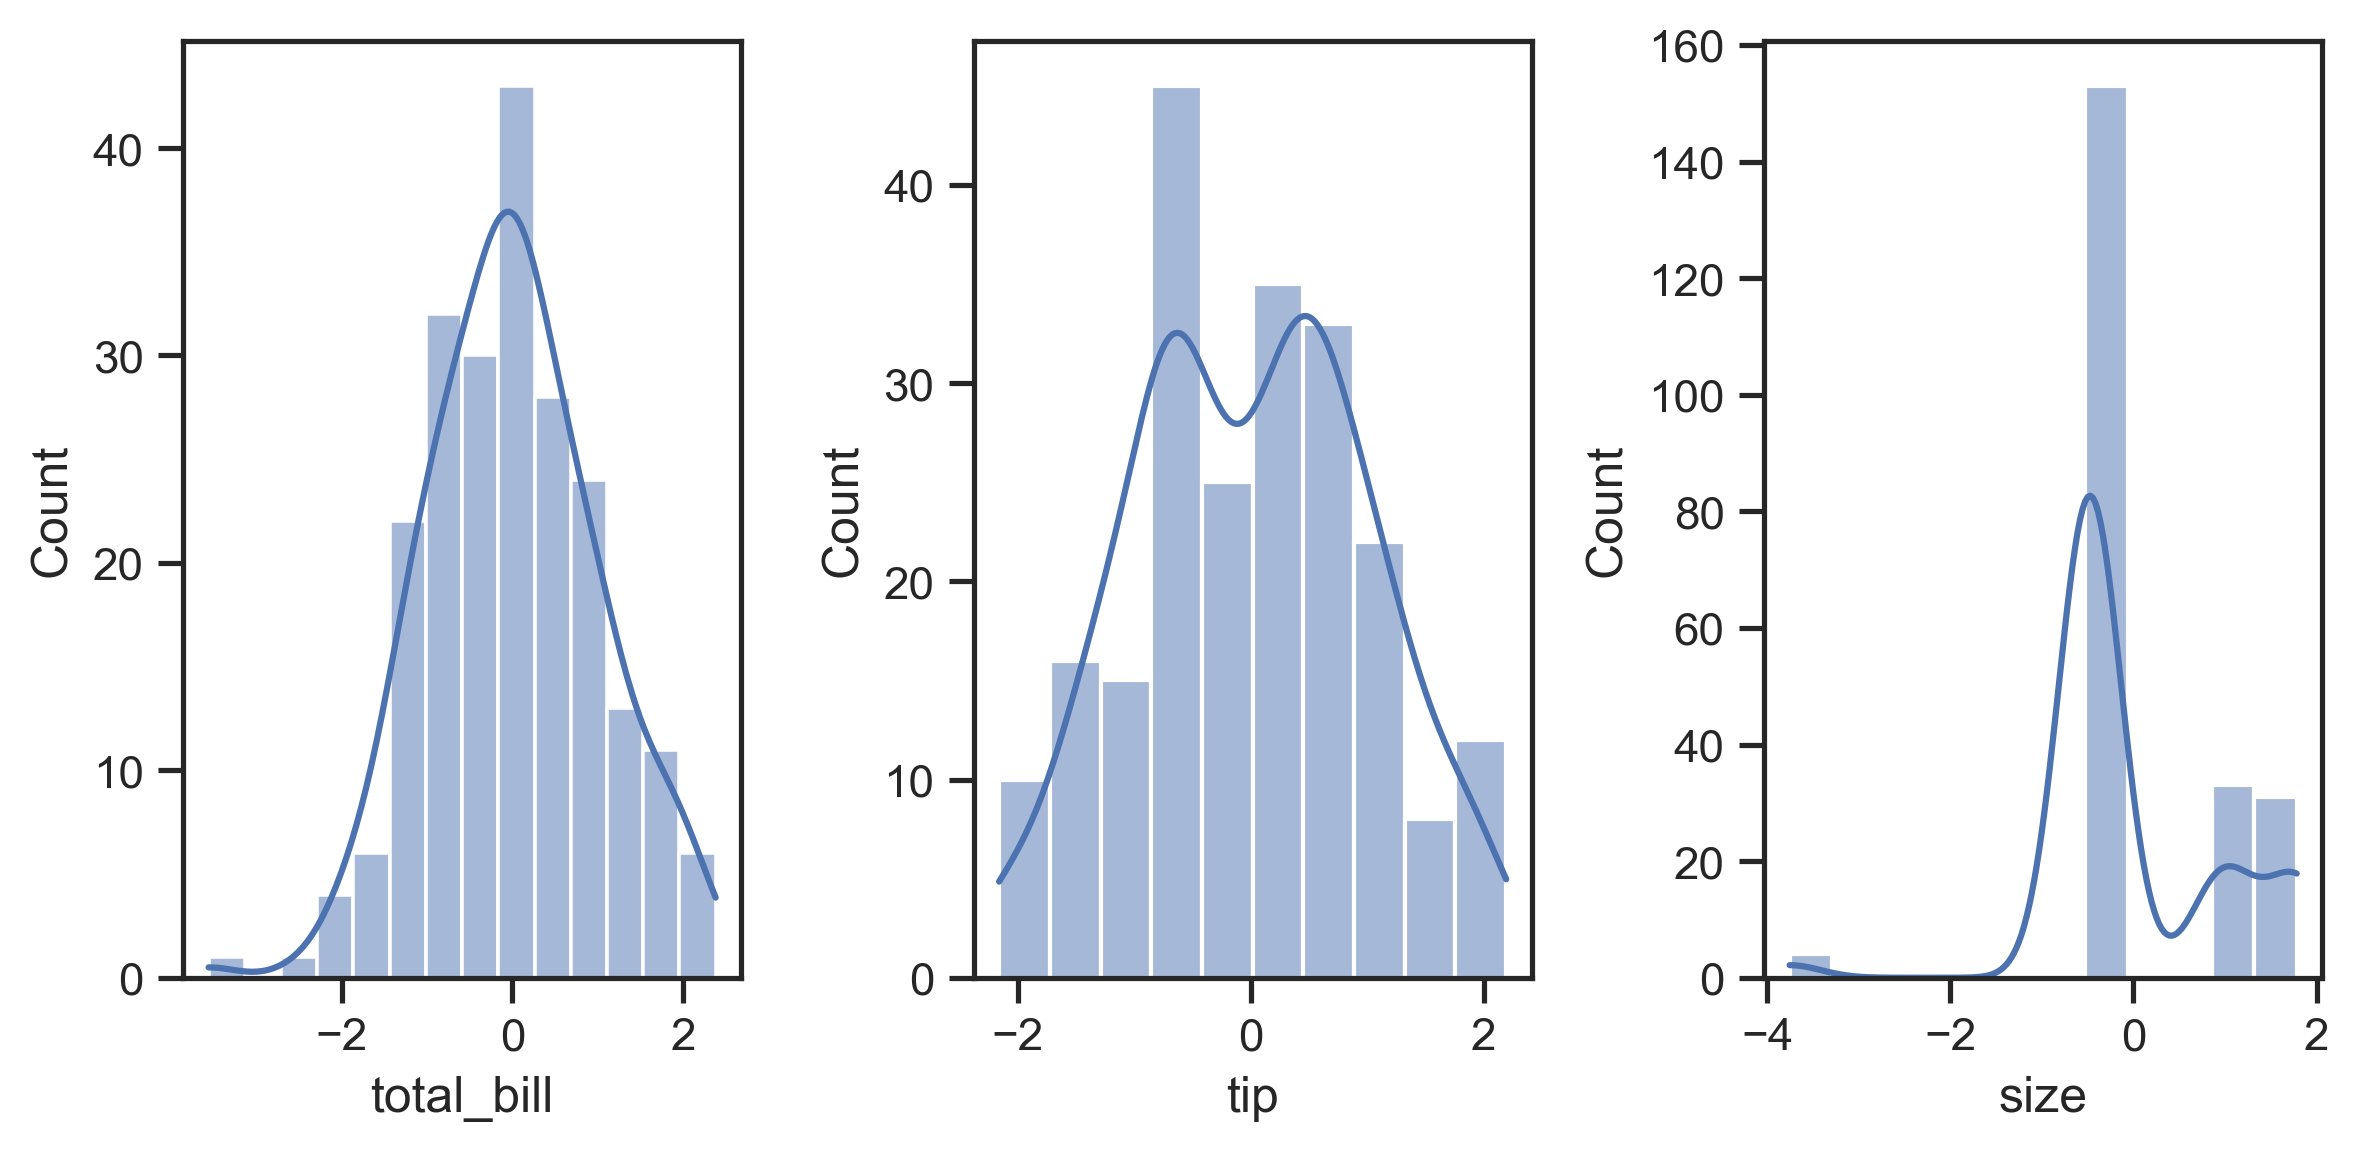

In [94]:
#Plotting distributions of numerical columns
fig = plt.figure(figsize=(8,4), dpi=300)
for i,col in enumerate(numerical_cols):
    plt.subplot(1, 3, i+1)
    sns.histplot(data=df, x=col, kde=True)
plt.tight_layout()
plt.show()

In [95]:
#Plotting Boxplots for numerical data

## Statistical Tests

# 2. Machine Learning

## Model Selection

## Model Evaluation

# 3. Conclusions